# Cluster Analysis of baseball players (position playes 2023)
This analysis will use data from baseball savant to see if players can be naturally grouped into clusters. I will use only data from 2023.

## Data Import and Subset

In [25]:
import pandas as pd
bat = pd.read_csv('player_batting_enriched.csv', index_col=['player_id'])
bat_23 = bat[bat['year']==2023]
num_c = ['player_age', 'ab', 'pa', 'hit', 'single',
       'double', 'triple', 'home_run', 'strikeout', 'walk', 'k_percent',
       'bb_percent', 'batting_avg', 'slg_percent', 'on_base_percent',
       'on_base_plus_slg', 'b_rbi', 'r_total_caught_stealing',
       'r_total_stolen_base', 'exit_velocity_avg', 'sweet_spot_percent',
       'barrel_batted_rate', 'hp_to_1b', 'sprint_speed', 'batting_avg']

subset = ['player_age', 'ab', 'on_base_plus_slg', 'exit_velocity_avg', 'sprint_speed']
bat_23_sub = bat_23[subset]

Let's check if there is any missing in the data:

In [26]:
bat_23_sub.isna().sum()

player_age            0
ab                    0
on_base_plus_slg      0
exit_velocity_avg     0
sprint_speed         11
dtype: int64

Because there are only 11 players with missing sprint speed, I will delete then from the table:

In [27]:
bat_23_sub = bat_23_sub[bat_23_sub['sprint_speed'].isna()==False]
bat_23_sub.isna().sum()

player_age           0
ab                   0
on_base_plus_slg     0
exit_velocity_avg    0
sprint_speed         0
dtype: int64

Ideally, our inputs should be independent, let's check the correlation of our inputs:

## Exploration of inputs

Pearson Correlation


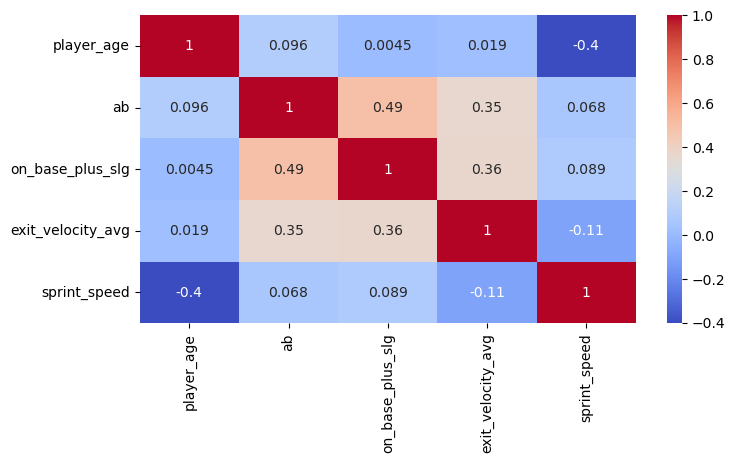

Spearman Correlation


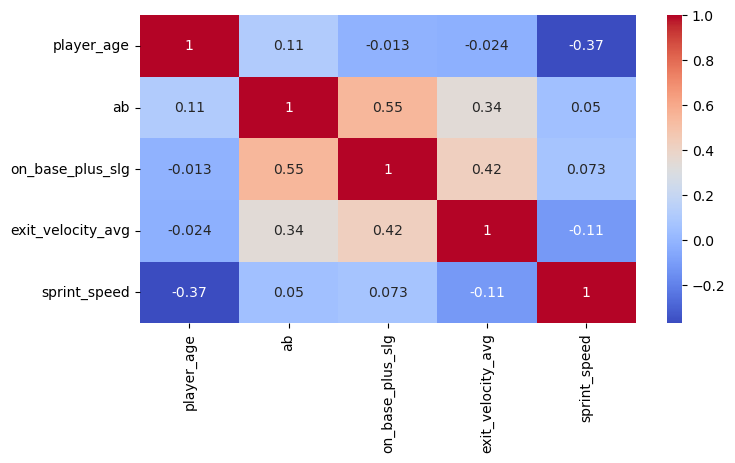

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
print('Pearson Correlation')
plt.figure(figsize=(8,4))
sns.heatmap(bat_23_sub.corr(),annot=True, cmap='coolwarm')
plt.show()
print('Spearman Correlation')
plt.figure(figsize=(8,4))
sns.heatmap(bat_23_sub.corr(method='spearman'),annot=True, cmap='coolwarm')
plt.show()

It is a good idea to also check the distribution of each variable:

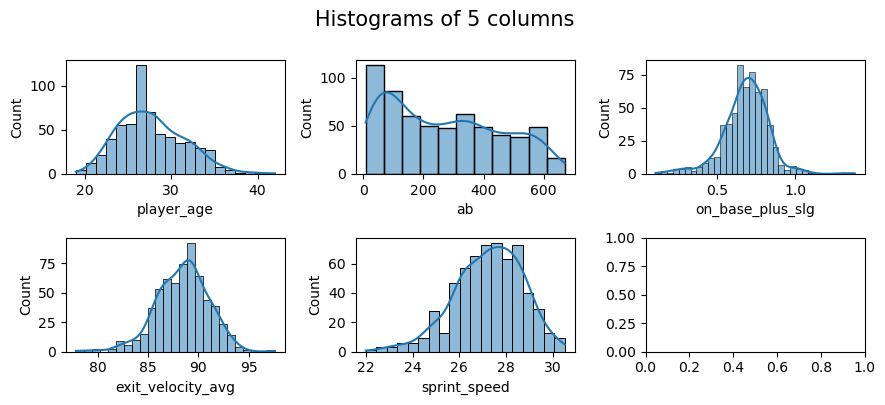

In [45]:
def hist_plots(data, columns, rem_ol=False, thres=0.99, scale_graph=9, n_cols=3, aspect_ratio=2/3 ):
    '''Create multiple Histograms plots using a subset of variables specified.
    
    Args:
        data: Input data-frame containing variables we wish to plot.
        columns: Listing of column-names we wish to plot.
        rem_ol: Remove observations greater than specific percentile defined by thres argument.
        thres: Percentile that will be used if rem_ol=True.
        scale_graph: Adjust the total size of the graph.
        n_cols: Adjust how many graphs we have on each row.
        aspect_ratio: Adjust the aspect ratio of each individual graph. For squared graphs use 1/1.
    '''

    # Adjusting how many rows the grid will have and proper sizes
    n_rows = len(columns)//n_cols+(len(columns)%n_cols>0) 
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(scale_graph, (scale_graph/n_cols)*aspect_ratio*n_rows))

    # Plotting
    fig.suptitle(f'Histograms of {len(columns)} columns',y=1, size=15)
    axes=axes.flatten()
    for i,feature in enumerate(columns):
        if rem_ol:
            lim = data[feature].quantile([thres]).iloc[0]
            x = data[feature][data[feature]<lim]
            print(f'{feature}: Observations greater than P{round(thres*100)} removed')
        else:
            x=data[feature]
        sns.histplot(data=x,ax=axes[i], kde=True)
    plt.tight_layout()

hist_plots(data=bat_23_sub ,columns=subset)

## Scaler
Because the euclidian distances can be more influenced by variables with higher scale, we need to rescale the data. Some people like to rescale the data using sklearn methods, like MinMaxScaler or StandardScaler:


In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_standardized = scaler.fit_transform(bat_23_sub)
data_standardized

array([[ 3.25222827,  0.35162856, -0.06386624,  0.27103378, -2.92838838],
       [ 3.78228518, -0.6684634 , -0.01567974,  1.55959268, -1.7574382 ],
       [ 1.92708599,  0.67207629, -0.06386624,  0.34912826, -0.17321149],
       ...,
       [-1.25325547, -1.05834148, -0.35298527,  0.11484482,  0.24006505],
       [-1.25325547, -0.86073204, -0.18089061, -0.78324169,  1.89317118],
       [ 0.33691526,  1.43581006,  0.67958269,  0.23198654, -0.72424687]])

You can also create a function yourself:

In [30]:
def min_max_scaler(x):
    return (x-x.min())/(x.max()-x.min())

scaled = bat_23_sub.copy()
for x in subset:
    scaled[x]= min_max_scaler(scaled[x])
scaled

,player_age,ab,on_base_plus_slg,exit_velocity_avg,sprint_speed
player_id,,,,,
408234,0.913043,0.492447,0.446976,0.570707,0.117647
443558,1.000000,0.203927,0.452474,0.737374,0.317647
444482,0.695652,0.583082,0.446976,0.580808,0.588235
444489,0.739130,0.006042,0.505892,0.368687,0.235294
446334,0.782609,0.306647,0.479969,0.727273,0.494118
...,...,...,...,...,...
694384,0.086957,0.152568,0.491752,0.383838,0.564706
694497,0.043478,0.081571,0.747840,0.565657,0.917647
696100,0.173913,0.093656,0.413983,0.550505,0.658824


In the past, we used hierarchical clustering with samples to define the best number of groups. If your data is not huge, you can run k-means multiple times to decide best k:

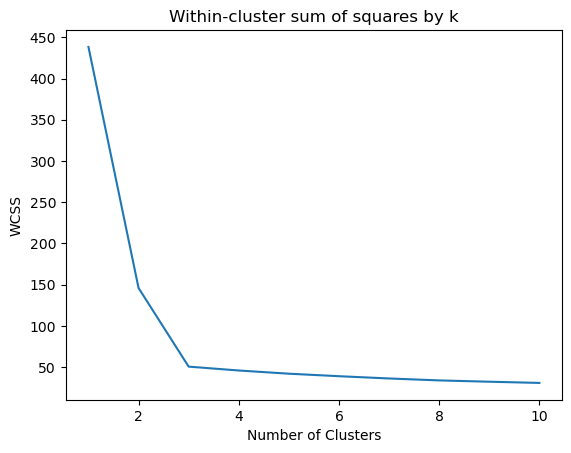

In [48]:
from sklearn.cluster import KMeans

wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=100) #n_init is the number of different initial seeds, reduce if your data is large.
    kmeans.fit(scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow method
plt.plot(range(1, 11), wcss)
plt.title('Within-cluster sum of squares by k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')  # Within-cluster sum of squares
plt.show()

3 clusters seem like a great idea. But let's have a look at PCA, to see if there is anything popping out of it:

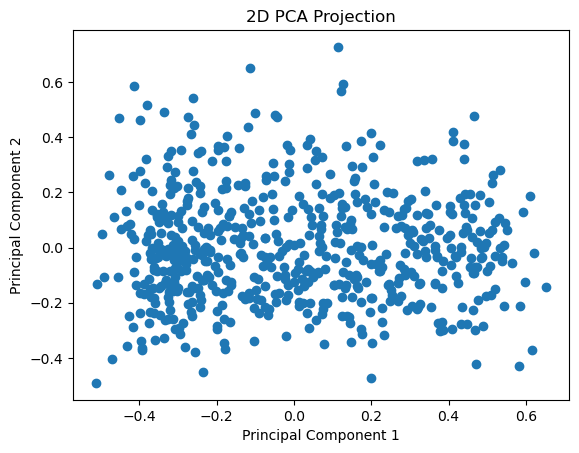

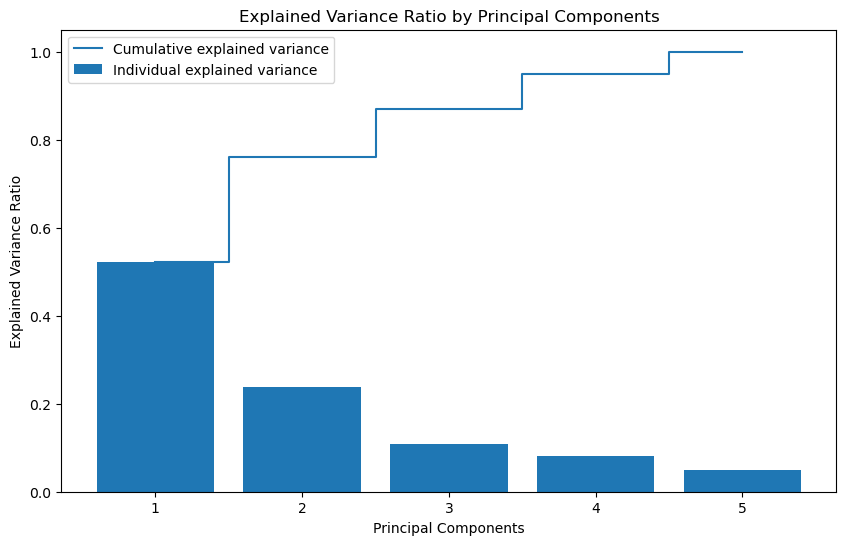

In [40]:
from sklearn.decomposition import PCA
import numpy as np
pca = PCA()
data_pca = pca.fit_transform(scaled)
plt.scatter(data_pca[:, 0], data_pca[:, 1])
plt.title('2D PCA Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, align='center',label='Individual explained variance')
plt.step(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, where='mid',label='Cumulative explained variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.legend()
plt.show()

PCA didn't give us anything special. I will use 3 clusters, but business needs may have a higher impact on this decision.

## k-means

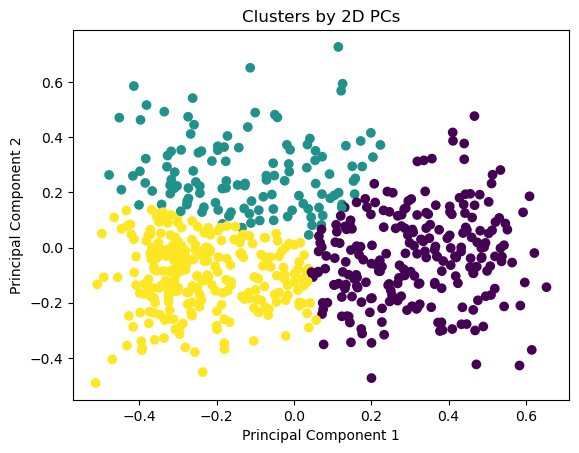

In [50]:
kmeans_final = KMeans(n_clusters=3, init='k-means++', n_init=200)
kmeans_final.fit(scaled)
scaled['Cluster'] = kmeans_final.labels_
plt.scatter(data_pca[:, 0], data_pca[:, 1],c=scaled['Cluster'], cmap='viridis')
plt.title('Clusters by 2D PCs')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Checking the frequency of each group:

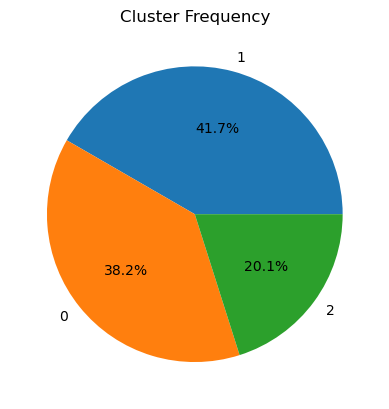

In [44]:
cluster_frequency = scaled['Cluster'].value_counts()
labels = cluster_frequency.index
sizes = cluster_frequency.values
plt.pie(sizes, labels=labels, autopct=lambda p: '{:.1f}%'.format(p))
plt.title('Cluster Frequency')
plt.show()

## Profiling of Clusters
We first need to get the final clusters to the original data (before standardization)

In [54]:
bat_23_sub['Cluster'] = kmeans_final.labels_

Depending on the number of inputs and final clusters, the best visualization of results can differ. For this case I will use violin plots:

In [55]:
def violin_plots(data, outcome, x_columns, scale_graph=9, n_cols=3, aspect_ratio=2/3 ):
    '''Create multiple violin plots by a categorical variable.
    
    Args:
        data: Input data-frame.
        outcome: Categorical variable that we will use as hue.
        x_columns: Listing of column-names we wish to plot against outcome.
        scale_graph: Adjust the total size of the graph.
        n_cols: Adjust how many graphs we have on each row.
        aspect_ratio: Adjust the aspect ratio of each individual graph. For squared graphs use 1/1.
    '''

    # Adjusting how many rows the grid will have and proper sizes
    n_rows = len(x_columns)//n_cols+(len(x_columns)%n_cols>0) 
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(scale_graph, (scale_graph/n_cols)*aspect_ratio*n_rows))

    # Plotting
    fig.suptitle(f'Violin plots of {len(x_columns)} columns by {outcome}',y=1, size=15)
    axes=axes.flatten()
    for i,feature in enumerate(x_columns):
        sns.violinplot(data=data, ax=axes[i],y=feature, x=outcome)
    plt.tight_layout()

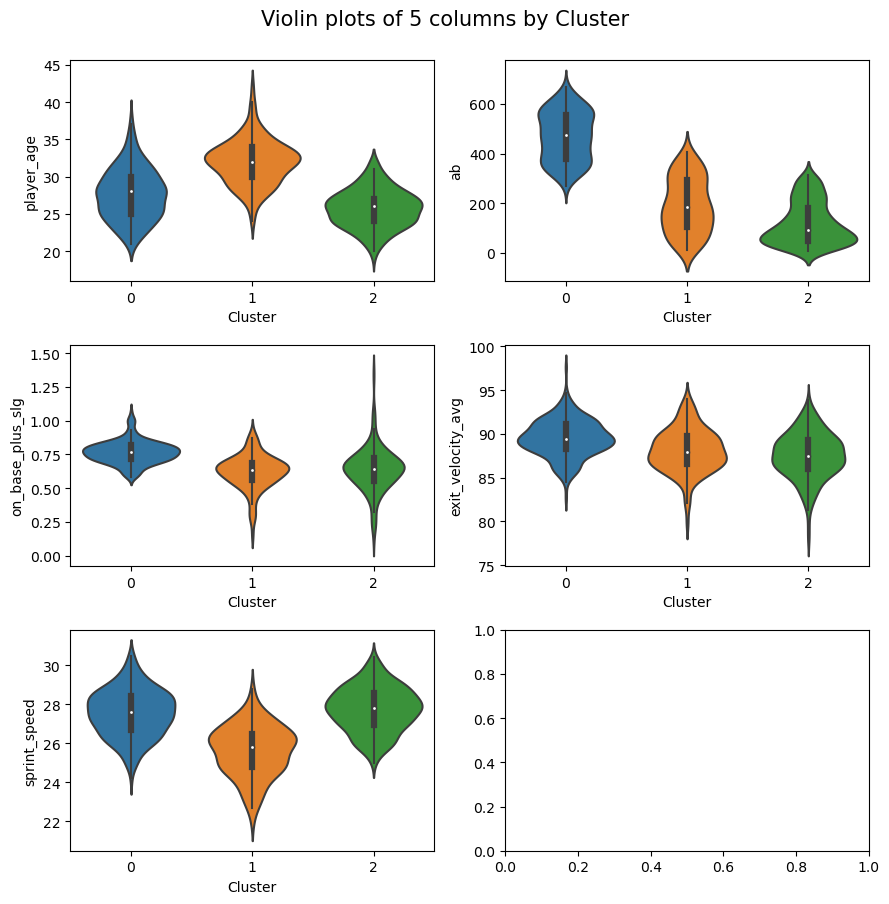

In [56]:
violin_plots(bat_23_sub, 'Cluster', subset , n_cols = 2)